In [1]:
# Author: Chad Lohrli 
# Date: December 24,2017
# Discription: Classifying MNIST w/ Convolutional Neural Network
# Framework: Tensorflow

In [2]:
#Libraries
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
%matplotlib inline

In [3]:
#Load Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
#preprare smaller dataset of 1000 samples from each class (10) => 10k samples
xtrain = mnist.train.images
ytrain = mnist.train.labels

counter = np.array([0,0,0,0,0,0,0,0,0,0])

xtrain10k = []
ytrain10k = []

i=0
while(np.sum(counter) < 10000):
    l = np.argmax(ytrain[i])
    if(counter[l] < 1000):
        counter[l] += 1
        xtrain10k.append(xtrain[i])
        ytrain10k.append(ytrain[i])
    i += 1
    
xtrain10k = np.asarray(xtrain10k)
ytrain10k = np.asarray(ytrain10k)

In [11]:
# Convolutional Network Model

'''

--CNN Architecture--

[CONV1 -> RELU -> MAXPOOL1] -> [CONV2 -> RELU -> MAXPOOL2] -> FC

CONV1    : filter (3x3), stride = 1, padding = 1 , filter size = 8
MAXPOOL1 : filter (2x2), stride = 2
CONV2    : filter (5x5), stride = 1, padding = 0, filter size = 16
MAXPOOL2 : filter (2x2), stride = 2

'''

def next_batch(batch_size, x, y):
    np.random.seed(random.randint(1,1000)) 
    idx = np.arange(0 , len(x))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    xb = [x[i] for i in idx]
    yb = [y[i] for i in idx]

    return np.asarray(xb), np.asarray(yb)

def init_params(f1,f2,nc,nc1,nc2):
    initializer = tf.contrib.layers.xavier_initializer(seed = 1)                                               
    w1 = tf.Variable(initializer([f1,f1,nc,nc1]))
    w2 = tf.Variable(initializer([f2,f2,nc1,nc2]))

    params = {"w1":w1,"w2":w2}
    return params
    

def forward(x,params):
    
    #filters
    w1 = params['w1']
    w2 = params['w2']

    layer_1 = tf.nn.conv2d(x,w1,strides=[1,1,1,1], padding="SAME")
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.max_pool(layer_1,ksize=[1,2,2,1],strides=[1,2,2,1], padding="VALID")
    
    layer_2 = tf.nn.conv2d(layer_1,w2,strides=[1,2,2,1],padding="VALID")
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.max_pool(layer_2,ksize=[1,2,2,1],strides=[1,2,2,1], padding="VALID")
    
    layer_2 = tf.contrib.layers.flatten(layer_2)
                                      
    FC = tf.contrib.layers.fully_connected(layer_2,10,activation_fn=None)
    
    
    return FC

def calculate_cost(FC,y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=FC,labels=y))
    return cost


def cnn_model(xtrain,ytrain,xtest,ytest,epochs,batch_size,rate,custom_data=False):
   
    tf.set_random_seed(1)
    #ops.reset_default_graph() #run model without resetting variables
    
    #Reshaping
    xtrain = xtrain.reshape(-1,28,28,1)
    xtest = xtest.reshape(-1,28,28,1)
    
    #Parameters
    train_size = xtrain.shape[0] #training examples
    nw = 28 #image width
    nh = 28 #image height
    nc = 1
    ny = 10 #label size
    seed = 1 #random seed
    costs = [] #accumulate costs
    train_acc = [] #accumulate train accuracy
    test_acc = [] # accumulate test accuracy
    
    #Filters
    f1 = 3 #filter 1 size (3x3)
    f2 = 5 #filter 2 size (5x5)
    nc1 = 8 #filter 1 depth (number of filters)
    nc2 = 16 #filter 2 depth (number of filters)
    
    x = tf.placeholder(tf.float32,[None,nh,nw,nc])
    y = tf.placeholder(tf.float32,[None,ny])

    params = init_params(f1,f2,nc,nc1,nc2)

    FC = forward(x,params)
    cost = calculate_cost(FC,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate).minimize(cost)
    
    predict = tf.equal(tf.argmax(FC,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(predict,"float"))
    
    init = tf.global_variables_initializer()
    
    #start session, this is where training happens
    with tf.Session() as sess:
        sess.run(init)
    
        for epoch in xrange(epochs+1):
            ecost = 0.
            batch_num = int(train_size / batch_size)
            for i in range(batch_num):
                xb = 0;
                yb = 0;
                if custom_data:
                    xb,yb, = next_batch(batch_size,xtrain,ytrain)
                else:
                    xb, yb = mnist.train.next_batch(batch_size)
                    
                xb = xb.reshape(-1,28,28,1)
                _, batch_cost = sess.run([optimizer,cost], feed_dict={x:xb,y:yb})
                ecost += batch_cost / batch_num
            
            if epoch % 5 == 0:
                print("epoch %i | cost %f" % (epoch,ecost))
                
            costs.append(ecost)
            train_acc.append(accuracy.eval({x:xtrain,y:ytrain}))
            test_acc.append(accuracy.eval({x:xtest,y:ytest}))
      
        params = sess.run(params)
        print("Train Accuracy:", accuracy.eval({x:xtrain,y:ytrain}))
        print("Test Accuracy:", accuracy.eval({x:xtest,y:ytest}))
    
    return train_acc,test_acc,params,costs


 #Data
xtrain = mnist.train.images
ytrain = mnist.train.labels
xtest = mnist.test.images
ytest = mnist.test.labels

#HyperParameters
batch_size = 128
epochs = 20
rate = 0.01 

In [12]:
#Run Model On Original Set
train_acc,test_acc,params, costs = cnn_model(xtrain,ytrain,xtest,ytest,epochs,batch_size,rate)

epoch 0 | cost 0.258983
epoch 5 | cost 0.064906
epoch 10 | cost 0.050863
epoch 15 | cost 0.045821
epoch 20 | cost 0.045564
('Train Accuracy:', 0.99010909)
('Test Accuracy:', 0.9774)


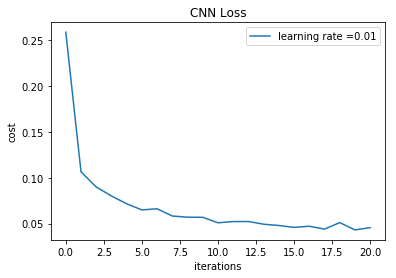

In [13]:
#Plot loss for original dataset
plt.plot(np.squeeze(costs),label="learning rate =" + str(rate))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("CNN Loss")
plt.legend()
plt.show()

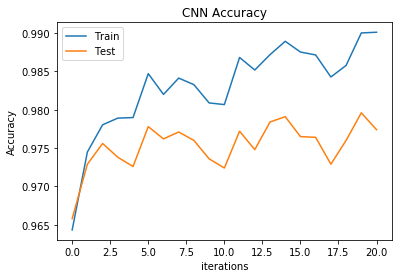

In [14]:
#Plot test and train accuracy on original dataset
plt.plot(train_acc,label="Train")
plt.plot(test_acc,label="Test")
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title("CNN Accuracy")
plt.legend()

In [15]:
#Run Model On Smaller Set
train_acc_10k,test_acc_10k,params10k, costs10k = cnn_model(xtrain10k,ytrain10k,xtest,ytest,epochs,batch_size,rate,True)

epoch 0 | cost 0.747991
epoch 5 | cost 0.096200
epoch 10 | cost 0.039296
epoch 15 | cost 0.025836
epoch 20 | cost 0.021434
('Train Accuracy:', 0.9939)
('Test Accuracy:', 0.96579999)


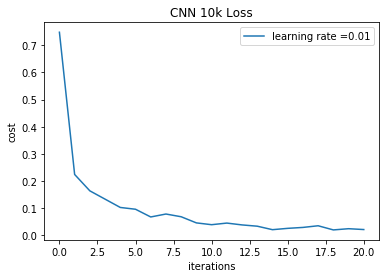

In [16]:
#plot loss on 10k dataset
plt.plot(np.squeeze(costs10k),label="learning rate =" + str(rate))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("CNN 10k Loss")
plt.legend()
plt.show()

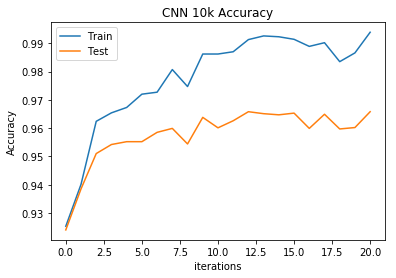

In [17]:
#Plot test and train accuracy on 10k dataset
plt.plot(train_acc_10k,label="Train")
plt.plot(test_acc_10k,label="Test")
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title("CNN 10k Accuracy")
plt.legend()

In [18]:
# Analysis: The model trained on the smaller dataset has a higher training accuracy yet lower test accuracy with 
# respect to the larger dataset. This may be due to the nature of stochastic gradient descent, the more data still
# yields higher test accuracy which is our standard for evaluation